# Первые неудачные попытки

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
# Определение архитектуры нейронной сети
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')  # 7 классов для видов птиц
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision()])

# Создание генератора данных для обучения
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_datasets/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Обучение модели
model.fit(train_generator, epochs=10)

Found 1331 images belonging to 7 classes.
Epoch 1/10
42/42 [==============================] - 295s 7s/step - loss: 2.1185 - accuracy: 0.1863 - precision_1: 0.1875
Epoch 2/10
42/42 [==============================] - 103s 2s/step - loss: 1.5811 - accuracy: 0.4192 - precision_1: 0.7085
Epoch 3/10
42/42 [==============================] - 96s 2s/step - loss: 1.3738 - accuracy: 0.5034 - precision_1: 0.7267
Epoch 4/10
42/42 [==============================] - 94s 2s/step - loss: 1.2374 - accuracy: 0.5657 - precision_1: 0.7553
Epoch 5/10
42/42 [==============================] - 94s 2s/step - loss: 1.1339 - accuracy: 0.5890 - precision_1: 0.7514
Epoch 6/10
42/42 [==============================] - 95s 2s/step - loss: 1.0371 - accuracy: 0.6364 - precision_1: 0.7926
Epoch 7/10
42/42 [==============================] - 102s 2s/step - loss: 0.9471 - accuracy: 0.6679 - precision_1: 0.8038
Epoch 8/10
42/42 [==============================] - 97s 2s/step - loss: 0.8421 - accuracy: 0.6957 - precision_1: 0.

In [ ]:
# Создание генератора данных для тестирования
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Оценка модели на тестовых данных
evaluation_results = model.evaluate(test_generator)

In [ ]:

# Вывод метрик
print("Test Accuracy:", evaluation_results[1])
print("Test Precision:", evaluation_results[2])

# Предсказания для построения матрицы ошибок и отчета классификации
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Матрица ошибок
conf_matrix = confusion_matrix(y_true, y_pred.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Отчет классификации
class_names = list(test_generator.class_indices.keys())
class_report = classification_report(y_true, y_pred.argmax(axis=1), target_names=class_names)
print("Classification Report:")
print(class_report)

9/9 [==============================] - 52s 6s/step - loss: 0.1361 - accuracy: 0.9571 - precision: 0.9673
Test Accuracy: 0.9571428298950195
Test Precision: 0.9672726988792419
9/9 [==============================] - 11s 1s/step
Confusion Matrix:
[[ 5  7  5  6  3  7  7]
 [ 5  3  4  6  6  5 11]
 [ 6  4 10  2  5 10  3]
 [ 3  9  9  4  3  8  4]
 [10  7  5  7  5  3  3]
 [ 6  7  4  6  5  6  6]
 [ 5  5  5  5 10  4  6]]
Classification Report:
              precision    recall  f1-score   support

        гусь       0.12      0.12      0.12        40
      индюки       0.07      0.07      0.07        40
      курица       0.24      0.25      0.24        40
       петух       0.11      0.10      0.11        40
      страус       0.14      0.12      0.13        40
        утка       0.14      0.15      0.14        40
    цыпленок       0.15      0.15      0.15        40

    accuracy                           0.14       280
   macro avg       0.14      0.14      0.14       280
weighted avg       0.14

После первого цикла обучения *(по ошибке не сохранила ячейки с кодом)* и теста показатели accuracy для каждого класса были низкими. Решила проверить, есть ли дисбаланс классов в обучающей выборке.

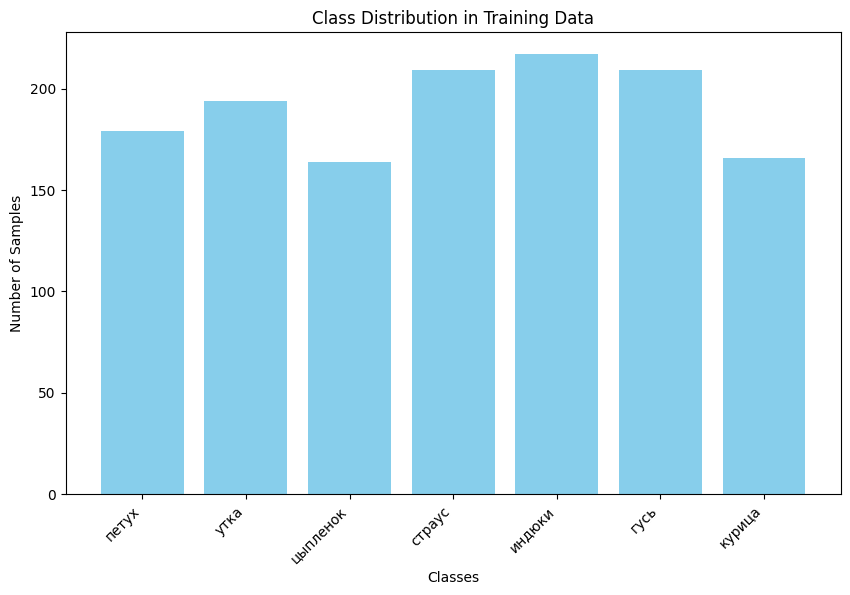

In [ ]:
import matplotlib.pyplot as plt
import os
from collections import Counter

# Путь к каталогу с обучающими данными
train_data_path = '/content/drive/MyDrive/birds_datasets/train'

# Получение списка классов
classes = os.listdir(train_data_path)

# Подсчет количества образцов в каждом классе
class_counts = Counter()

for class_name in classes:
    class_path = os.path.join(train_data_path, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45, ha='right')
plt.show()

Значительного дисбаланса нет, но при отсутствии лучших идей решила попробовать всё равно учитывать веса классов при обучении, с сохранением остальных параметров. В качестве метрик пока использовала только accuracy и precision, потому что пока не знала, какие ещё стоит взять.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_datasets/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

class_counts = np.bincount(train_generator.classes)

# Расчет весов классов
total_samples = np.sum(class_counts)
class_weights = {class_idx: total_samples / (len(class_counts) * class_count) for class_idx, class_count in enumerate(class_counts)}

# Определение архитектуры нейронной сети
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')  # 7 классов для видов птиц
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision()])


Затем изменила batch_size и вновь переобучила модель.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_datasets/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

class_counts = np.bincount(train_generator.classes)

# Расчет весов классов
total_samples = np.sum(class_counts)
class_weights = {class_idx: total_samples / (len(class_counts) * class_count) for class_idx, class_count in enumerate(class_counts)}

# Определение архитектуры нейронной сети
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')  # 7 классов для видов птиц
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision()])


In [ ]:
model.fit(train_generator, epochs=10, class_weight=class_weights)

Epoch 1/10
84/84 [==============================] - 191s 2s/step - loss: 1.8524 - accuracy: 0.2810 - precision_1: 0.4848
Epoch 2/10
84/84 [==============================] - 184s 2s/step - loss: 1.4208 - accuracy: 0.4485 - precision_1: 0.7158
Epoch 3/10
84/84 [==============================] - 183s 2s/step - loss: 1.2265 - accuracy: 0.5605 - precision_1: 0.7740
Epoch 4/10
84/84 [==============================] - 184s 2s/step - loss: 1.1915 - accuracy: 0.5477 - precision_1: 0.7399
Epoch 5/10
84/84 [==============================] - 186s 2s/step - loss: 1.0661 - accuracy: 0.6258 - precision_1: 0.7657
Epoch 6/10
84/84 [==============================] - 189s 2s/step - loss: 0.9685 - accuracy: 0.6409 - precision_1: 0.7724
Epoch 7/10
84/84 [==============================] - 185s 2s/step - loss: 0.9058 - accuracy: 0.6784 - precision_1: 0.7857
Epoch 8/10
84/84 [==============================] - 184s 2s/step - loss: 0.8118 - accuracy: 0.7220 - precision_1: 0.8186
Epoch 9/10
84/84 [==============

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_datasets/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

model.fit(train_generator, epochs=11, class_weight=class_weights)

Found 1331 images belonging to 7 classes.
Epoch 1/11
84/84 [==============================] - 182s 2s/step - loss: 0.6038 - accuracy: 0.8039 - precision_1: 0.8552
Epoch 2/11
84/84 [==============================] - 182s 2s/step - loss: 0.5516 - accuracy: 0.8137 - precision_1: 0.8654
Epoch 3/11
84/84 [==============================] - 182s 2s/step - loss: 0.4782 - accuracy: 0.8370 - precision_1: 0.8856
Epoch 4/11
84/84 [==============================] - 181s 2s/step - loss: 0.4640 - accuracy: 0.8422 - precision_1: 0.8796
Epoch 5/11
84/84 [==============================] - 193s 2s/step - loss: 0.3703 - accuracy: 0.8693 - precision_1: 0.8994
Epoch 6/11
84/84 [==============================] - 231s 3s/step - loss: 0.3752 - accuracy: 0.8573 - precision_1: 0.8892
Epoch 7/11
84/84 [==============================] - 227s 3s/step - loss: 0.3639 - accuracy: 0.8768 - precision_1: 0.8975
Epoch 8/11
84/84 [==============================] - 222s 3s/step - loss: 0.3213 - accuracy: 0.8843 - precision_

In [ ]:
# Создание генератора данных для тестирования
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_datasets/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

evaluation_results = model.evaluate(test_generator)

Found 280 images belonging to 7 classes.
9/9 [==============================] - 48s 6s/step - loss: 0.1223 - accuracy: 0.9607 - precision_1: 0.9640


In [ ]:
# Вывод метрик
print("Test Accuracy:", evaluation_results[1])
print("Test Precision:", evaluation_results[2])

# Предсказания для построения матрицы ошибок и отчета классификации
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Матрица ошибок
conf_matrix = confusion_matrix(y_true, y_pred.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Отчет классификации
class_names = list(test_generator.class_indices.keys())
class_report = classification_report(y_true, y_pred.argmax(axis=1), target_names=class_names)
print("Classification Report:")
print(class_report)

Test Accuracy: 0.9607142806053162
Test Precision: 0.9640287756919861
9/9 [==============================] - 18s 2s/step
Confusion Matrix:
[[ 3  5  8  7  9  4  4]
 [ 3  5  7  6  4 10  5]
 [ 8  8  5  5  3  3  8]
 [ 4 10  3  5  6  5  7]
 [ 5  5  6  6  8  8  2]
 [ 7  3  6  4  4 12  4]
 [ 5  5  7  5  4  4 10]]
Classification Report:
              precision    recall  f1-score   support

        гусь       0.09      0.07      0.08        40
      индюки       0.12      0.12      0.12        40
      курица       0.12      0.12      0.12        40
       петух       0.13      0.12      0.13        40
      страус       0.21      0.20      0.21        40
        утка       0.26      0.30      0.28        40
    цыпленок       0.25      0.25      0.25        40

    accuracy                           0.17       280
   macro avg       0.17      0.17      0.17       280
weighted avg       0.17      0.17      0.17       280



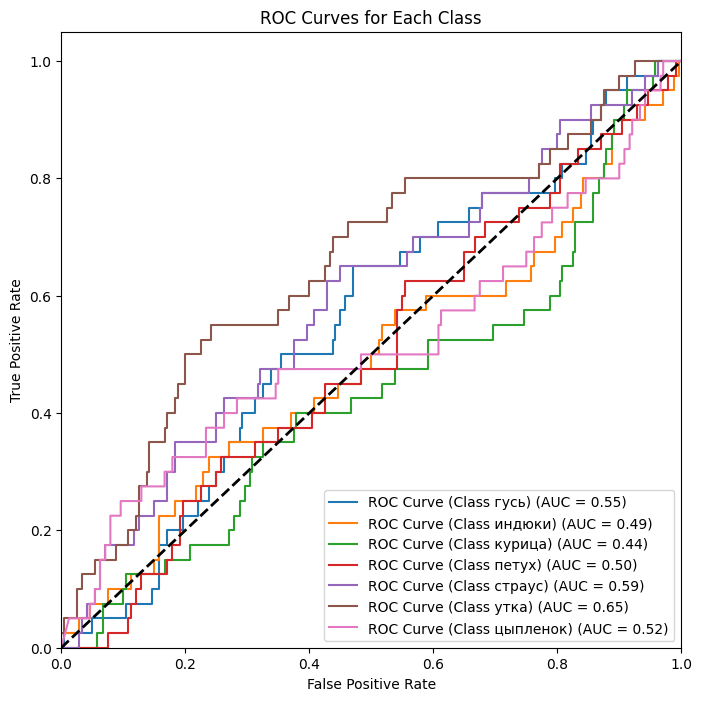

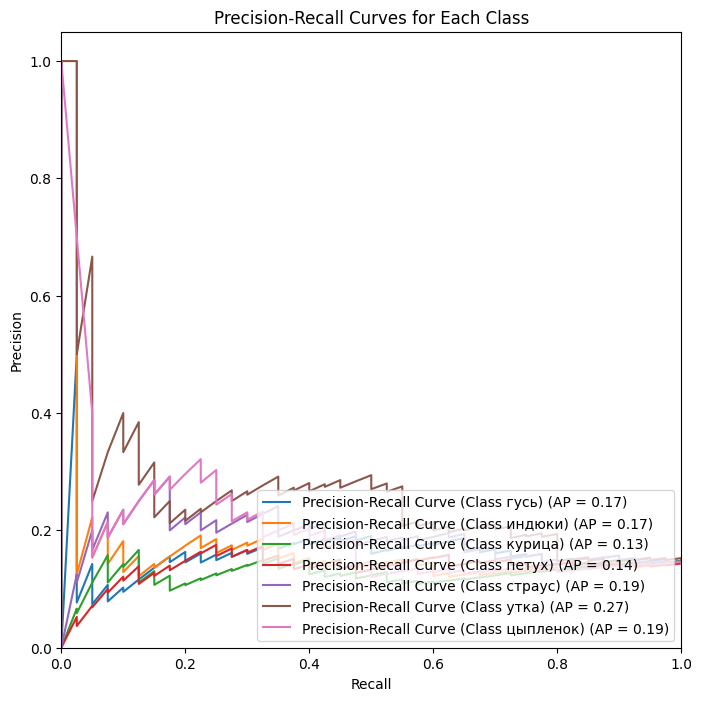

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Визуализация ROC-кривых
fpr = dict()
tpr = dict()
roc_auc = dict()

# Получение ROC-кривых для каждого класса
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Рисование ROC-кривых
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC Curve (Class {class_names[i]}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

# Визуализация Precision-Recall кривых
precision = dict()
recall = dict()
average_precision = dict()

# Получение Precision-Recall кривых для каждого класса
for i in range(len(class_names)):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred[:, i])

# Рисование Precision-Recall кривых
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(recall[i], precision[i], label=f'Precision-Recall Curve (Class {class_names[i]}) (AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

Результаты все еще не соответствовали нужным.

Добавила метрику Recall, потому что противоречие между показателями точности при общем тесте и этими же показателями для отдельных классов заставило задуматься, что при обучении одна только метрика Precision не объективна.
Хотела использовать F1, чтобы сразу понимать соотношение Precision и Recall, но возникли проблемы.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.4, zoom_range=0.2)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_datasets/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

class_counts = np.bincount(train_generator.classes)

# Расчет весов классов
total_samples = np.sum(class_counts)
class_weights = {class_idx: total_samples / (len(class_counts) * class_count) for class_idx, class_count in enumerate(class_counts)}

# Определение архитектуры нейронной сети
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')  # 7 классов для видов птиц
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


Found 1331 images belonging to 7 classes.


In [ ]:
model.fit(train_generator, epochs=11, class_weight=class_weights)

Epoch 1/11
84/84 [==============================] - 200s 2s/step - loss: 1.7677 - accuracy: 0.3080 - precision_2: 0.5635 - recall_2: 0.0533
Epoch 2/11
84/84 [==============================] - 180s 2s/step - loss: 1.3625 - accuracy: 0.4959 - precision_2: 0.7253 - recall_2: 0.2539
Epoch 3/11
84/84 [==============================] - 178s 2s/step - loss: 1.1695 - accuracy: 0.5815 - precision_2: 0.7441 - recall_2: 0.3779
Epoch 4/11
84/84 [==============================] - 181s 2s/step - loss: 1.0355 - accuracy: 0.6221 - precision_2: 0.7765 - recall_2: 0.4621
Epoch 5/11
84/84 [==============================] - 181s 2s/step - loss: 0.8747 - accuracy: 0.6702 - precision_2: 0.8002 - recall_2: 0.5507
Epoch 6/11
84/84 [==============================] - 184s 2s/step - loss: 0.7406 - accuracy: 0.7446 - precision_2: 0.8226 - recall_2: 0.6514
Epoch 7/11
84/84 [==============================] - 183s 2s/step - loss: 0.5730 - accuracy: 0.7904 - precision_2: 0.8631 - recall_2: 0.7153
Epoch 8/11
84/84 [==

In [ ]:
# Создание генератора данных для тестирования
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_datasets/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

evaluation_results = model.evaluate(test_generator)

In [ ]:
# Вывод метрик
print("Test Accuracy:", evaluation_results[1])
print("Test Precision:", evaluation_results[2])

# Предсказания для построения матрицы ошибок и отчета классификации
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Матрица ошибок
conf_matrix = confusion_matrix(y_true, y_pred.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Отчет классификации
class_names = list(test_generator.class_indices.keys())
class_report = classification_report(y_true, y_pred.argmax(axis=1), target_names=class_names)
print("Classification Report:")
print(class_report)

Test Accuracy: 0.9321428537368774
Test Precision: 0.94525545835495
9/9 [==============================] - 15s 2s/step
Confusion Matrix:
[[ 7  3  8  4  5  8  5]
 [ 8  4  9  5  5  7  2]
 [ 4  7  5  6  5  7  6]
 [ 7  4  4  4 11  4  6]
 [ 5  7  6  2  7  3 10]
 [ 5  5  6 10  3  8  3]
 [ 8  5  8  5  3  7  4]]
Classification Report:
              precision    recall  f1-score   support

        гусь       0.16      0.17      0.17        40
      индюки       0.11      0.10      0.11        40
      курица       0.11      0.12      0.12        40
       петух       0.11      0.10      0.11        40
      страус       0.18      0.17      0.18        40
        утка       0.18      0.20      0.19        40
    цыпленок       0.11      0.10      0.11        40

    accuracy                           0.14       280
   macro avg       0.14      0.14      0.14       280
weighted avg       0.14      0.14      0.14       280



# Более удачные попытки

После еще нескольких подобных попыток с разными параметрами для генерации обучающей выборки, ни одна из которых не улучшала ситуацию на тестовых данных, наконец-то решила использовать уже обученную модель в качестве основы.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import optimizers

In [ ]:
# Загрузка предварительно обученной модели InceptionV3 без верхних слоев
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Добавление своих слоев поверх предварительно обученной модели
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')  # 7 классов для видов птиц
])

# Заморозка весов предварительно обученной модели
base_model.trainable = False

# Компиляция модели
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Создание генератора данных для обучения
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.4, zoom_range=0.4, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_datasets/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1331 images belonging to 7 classes.


In [ ]:
model.fit(train_generator, epochs=5)

Epoch 1/5
42/42 [==============================] - 200s 5s/step - loss: 0.7779 - accuracy: 0.7295 - precision_1: 0.8315 - recall_1: 0.6634
Epoch 2/5
42/42 [==============================] - 196s 5s/step - loss: 0.3384 - accuracy: 0.8768 - precision_1: 0.9093 - recall_1: 0.8512
Epoch 3/5
42/42 [==============================] - 193s 5s/step - loss: 0.2619 - accuracy: 0.9053 - precision_1: 0.9194 - recall_1: 0.8828
Epoch 4/5
42/42 [==============================] - 194s 5s/step - loss: 0.2326 - accuracy: 0.9249 - precision_1: 0.9335 - recall_1: 0.9076
Epoch 5/5
42/42 [==============================] - 198s 5s/step - loss: 0.1944 - accuracy: 0.9384 - precision_1: 0.9492 - recall_1: 0.9256


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_datasets/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

evaluation_results = model.evaluate(test_generator)

# Вывод метрик
print("Test Accuracy:", evaluation_results[1])
print("Test Precision:", evaluation_results[2])

# Предсказания для построения матрицы ошибок и отчета классификации
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Матрица ошибок
conf_matrix = confusion_matrix(y_true, y_pred.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Отчет классификации
class_names = list(test_generator.class_indices.keys())
class_report = classification_report(y_true, y_pred.argmax(axis=1), target_names=class_names)
print("Classification Report:")

Found 280 images belonging to 7 classes.
9/9 [==============================] - 38s 4s/step - loss: 0.1358 - accuracy: 0.9536 - precision_1: 0.9567 - recall_1: 0.9464
Test Accuracy: 0.9535714387893677
Test Precision: 0.9566786885261536
9/9 [==============================] - 37s 4s/step
Confusion Matrix:
[[ 6  6 10  4  2  5  7]
 [ 3  9  5  3  6  8  6]
 [ 3  5 11  5  7  4  5]
 [ 5  6  6  6  8  3  6]
 [ 6  6  3  6  7  4  8]
 [10  3  5  5  7  8  2]
 [ 6  3 11  4  3  6  7]]
Classification Report:
              precision    recall  f1-score   support

        гусь       0.15      0.15      0.15        40
      индюки       0.24      0.23      0.23        40
      курица       0.22      0.28      0.24        40
       петух       0.18      0.15      0.16        40
      страус       0.17      0.17      0.17        40
        утка       0.21      0.20      0.21        40
    цыпленок       0.17      0.17      0.17        40

    accuracy                           0.19       280
   macro avg   

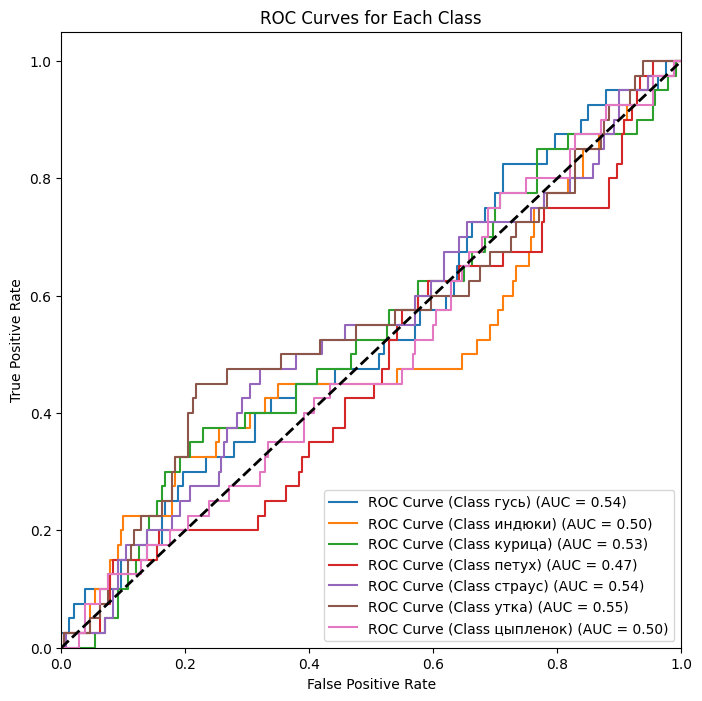

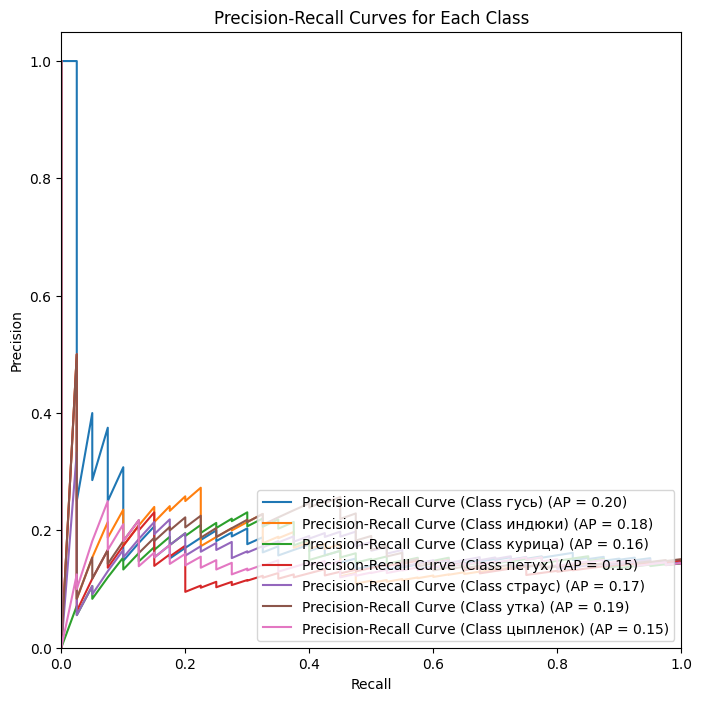

              precision    recall  f1-score   support

        гусь       0.15      0.15      0.15        40
      индюки       0.24      0.23      0.23        40
      курица       0.22      0.28      0.24        40
       петух       0.18      0.15      0.16        40
      страус       0.17      0.17      0.17        40
        утка       0.21      0.20      0.21        40
    цыпленок       0.17      0.17      0.17        40

    accuracy                           0.19       280
   macro avg       0.19      0.19      0.19       280
weighted avg       0.19      0.19      0.19       280



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Визуализация ROC-кривых
fpr = dict()
tpr = dict()
roc_auc = dict()

# Получение ROC-кривых для каждого класса
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Рисование ROC-кривых
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC Curve (Class {class_names[i]}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

# Визуализация Precision-Recall кривых
precision = dict()
recall = dict()
average_precision = dict()

# Получение Precision-Recall кривых для каждого класса
for i in range(len(class_names)):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred[:, i])

# Рисование Precision-Recall кривых
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(recall[i], precision[i], label=f'Precision-Recall Curve (Class {class_names[i]}) (AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend(loc="lower right")
plt.show()
print(class_report)

Показатели все еще далеки от цели, но появились изменения в лучшую сторону.

# Использованная в итоге модель

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import optimizers

In [ ]:
# Загрузка предварительно обученной модели InceptionV3 без верхних слоев
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Добавление своих слоев поверх предварительно обученной модели
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')  # 7 классов для видов птиц
])

# Заморозка весов предварительно обученной модели
base_model.trainable = False

# Компиляция модели
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Создание генератора данных для обучения
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.5, zoom_range=0.5, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_datasets/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

87910968/87910968 [==============================] - 0s 0us/step
Found 1331 images belonging to 7 classes.


In [ ]:
history=model.fit(train_generator, epochs=6)

Epoch 1/6
42/42 [==============================] - 330s 8s/step - loss: 0.6781 - accuracy: 0.7671 - precision: 0.8591 - recall: 0.7055
Epoch 2/6
42/42 [==============================] - 162s 4s/step - loss: 0.3602 - accuracy: 0.8881 - precision: 0.9102 - recall: 0.8527
Epoch 3/6
42/42 [==============================] - 162s 4s/step - loss: 0.3500 - accuracy: 0.8738 - precision: 0.8986 - recall: 0.8588
Epoch 4/6
42/42 [==============================] - 166s 4s/step - loss: 0.2743 - accuracy: 0.9053 - precision: 0.9181 - recall: 0.8933
Epoch 5/6
42/42 [==============================] - 165s 4s/step - loss: 0.2722 - accuracy: 0.8956 - precision: 0.9158 - recall: 0.8820
Epoch 6/6
42/42 [==============================] - 164s 4s/step - loss: 0.2571 - accuracy: 0.9068 - precision: 0.9268 - recall: 0.8941


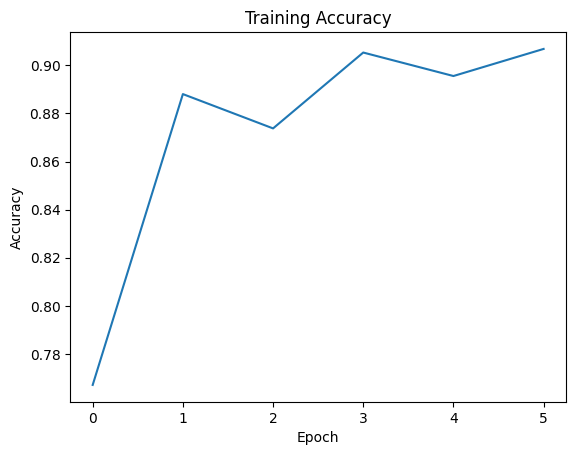

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/birds_datasets/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

evaluation_results = model.evaluate(test_generator)


# Вывод метрик
print("Test Accuracy:", evaluation_results[1])
print("Test Precision:", evaluation_results[2])


# Предсказания для построения матрицы ошибок и отчета классификации
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Матрица ошибок
conf_matrix = confusion_matrix(y_true, y_pred.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Отчет классификации
class_names = list(test_generator.class_indices.keys())
class_report = classification_report(y_true, y_pred.argmax(axis=1), target_names=class_names)
print("Classification Report:")
print(class_report)


Found 280 images belonging to 7 classes.
9/9 [==============================] - 32s 3s/step - loss: 0.2856 - accuracy: 0.9071 - precision: 0.9091 - recall: 0.8929
Test Accuracy: 0.9071428775787354
Test Precision: 0.9090909361839294
9/9 [==============================] - 32s 3s/step
Confusion Matrix:
[[ 4  3 11  3  3  8  8]
 [ 6  3  8  7  7  5  4]
 [ 5  4  4  3 10  7  7]
 [ 4  3  9  6  6  7  5]
 [ 2  4  9  4  6  7  8]
 [10  6  7  4  6  5  2]
 [ 7  3 10  3  4  6  7]]
Classification Report:
              precision    recall  f1-score   support

        гусь       0.11      0.10      0.10        40
      индюки       0.12      0.07      0.09        40
      курица       0.07      0.10      0.08        40
       петух       0.20      0.15      0.17        40
      страус       0.14      0.15      0.15        40
        утка       0.11      0.12      0.12        40
    цыпленок       0.17      0.17      0.17        40

    accuracy                           0.12       280
   macro avg       

In [ ]:
model.save('bird_recognition.keras')

In [ ]:
 from google.colab import files

files.download('bird_recognition.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

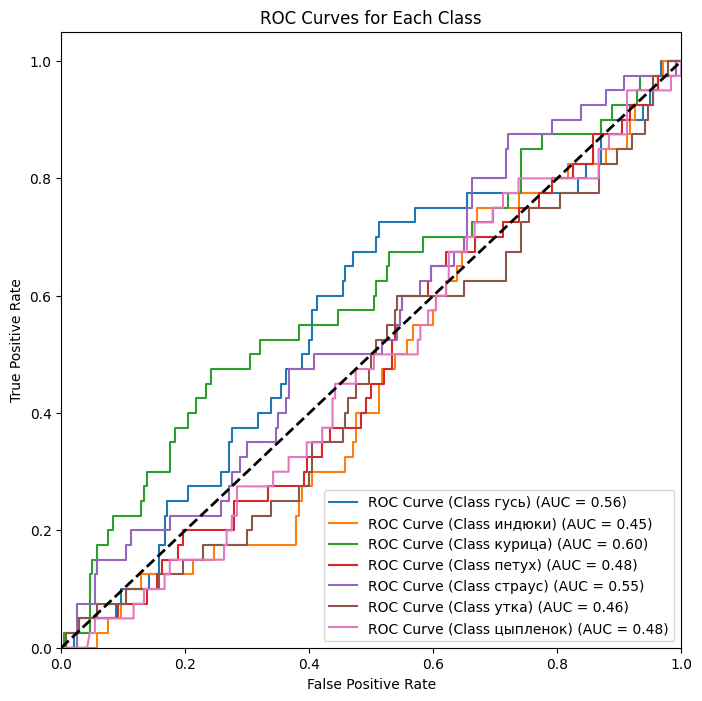

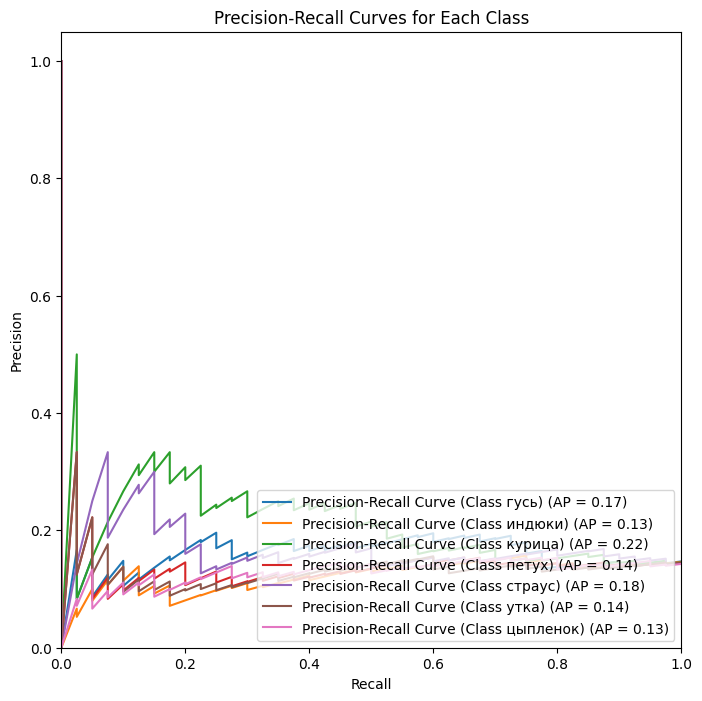

              precision    recall  f1-score   support

        гусь       0.12      0.12      0.12        40
      индюки       0.11      0.12      0.12        40
      курица       0.30      0.23      0.26        40
       петух       0.10      0.10      0.10        40
      страус       0.20      0.20      0.20        40
        утка       0.10      0.10      0.10        40
    цыпленок       0.10      0.10      0.10        40

    accuracy                           0.14       280
   macro avg       0.15      0.14      0.14       280
weighted avg       0.15      0.14      0.14       280



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Визуализация ROC-кривых
fpr = dict()
tpr = dict()
roc_auc = dict()

# Получение ROC-кривых для каждого класса
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Рисование ROC-кривых
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC Curve (Class {class_names[i]}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

# Визуализация Precision-Recall кривых
precision = dict()
recall = dict()
average_precision = dict()

# Получение Precision-Recall кривых для каждого класса
for i in range(len(class_names)):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred[:, i])

# Рисование Precision-Recall кривых
plt.figure(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(recall[i], precision[i], label=f'Precision-Recall Curve (Class {class_names[i]}) (AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend(loc="lower right")
plt.show()